In [1]:
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [2]:
steam_df = pd.read_csv('./data/steam-200k.csv', header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])

In [3]:
steam_df.head(25)

,UserID,Game,Action,Hours,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
5,151603712,Spore,play,14.9,0
6,151603712,Fallout New Vegas,purchase,1.0,0
7,151603712,Fallout New Vegas,play,12.1,0
8,151603712,Left 4 Dead 2,purchase,1.0,0
9,151603712,Left 4 Dead 2,play,8.9,0


In [4]:
steam_df.value_counts()

UserID     Game                                          Action    Hours  Other
93275329   Grand Theft Auto Vice City                    purchase  1.0    0        2
116876958  Grand Theft Auto III                          purchase  1.0    0        2
27169419   Sid Meier's Civilization IV Beyond the Sword  purchase  1.0    0        2
           Sid Meier's Civilization IV                   purchase  1.0    0        2
46028967   Sid Meier's Civilization IV                   purchase  1.0    0        2
                                                                                  ..
127072755  Mortal Kombat Komplete Edition                purchase  1.0    0        1
                                                         play      0.3    0        1
           Just Cause 2 Multiplayer Mod                  purchase  1.0    0        1
                                                         play      0.7    0        1
5250       Alien Swarm                                   play      4.9

In [ ]:
# dont run this cell
def parse(path):
    data = []
    g = gzip.open(path, 'r')
    for l in g:
        data.append(eval(l))
    return data

In [ ]:
#dont run this cell
import gzip
review_data = parse('./data/steam_reviews.json.gz')

In [ ]:
#dont run this cell
review_new = pd.DataFrame(review_data)

In [ ]:
#dont run this cell
review_new.head()

In [5]:
play_data = steam_df[steam_df['Action'] == 'play']

In [6]:
play_data_new = play_data.drop(['Action', 'Other'], axis=1)

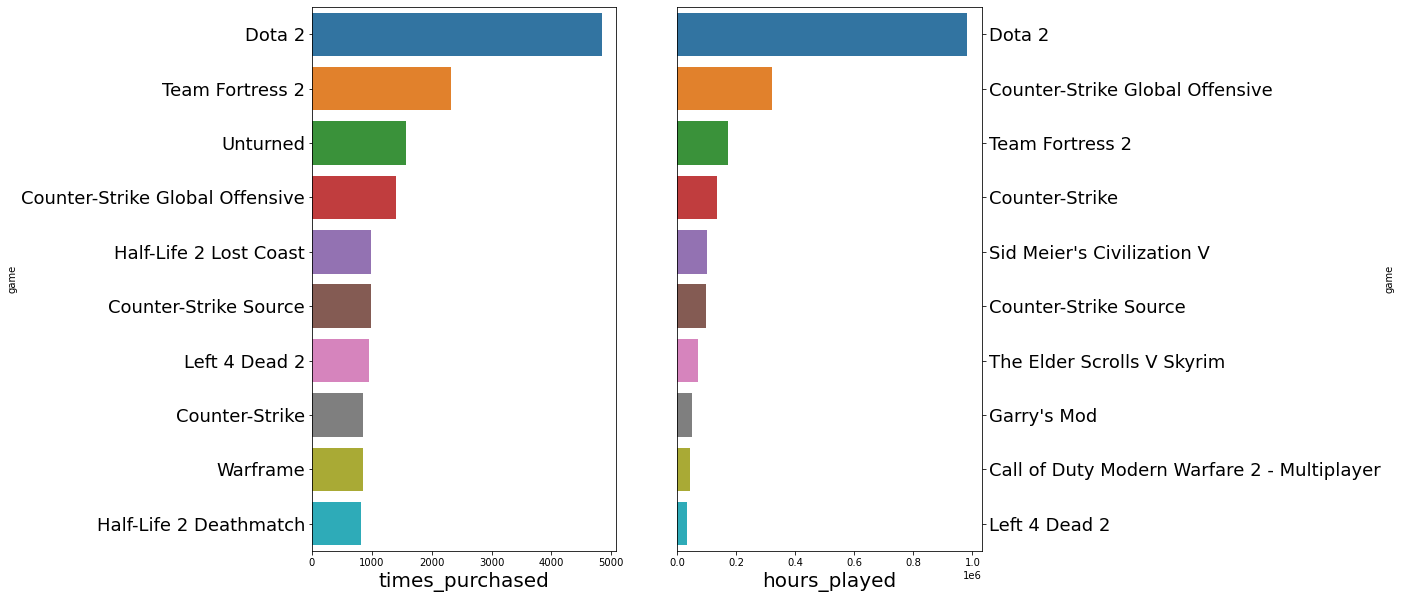

In [7]:
nb_games = 10
df_purchase = steam_df.loc[steam_df['Action'] == 'purchase']
purchased_times = df_purchase.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:nb_games]

play_data = steam_df[steam_df['Action'] == 'play']
hours_played = play_data.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

fig, ax = plt.subplots(1,2,figsize=(12,nb_games))

sns.barplot(y = 'game', x = 'times_purchased', data = purchased_times, ax=ax[0])
sns.barplot(y = 'game', x = 'hours_played', data = hours_played, ax=ax[1])


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i in range(0,2):
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].xaxis.label.set_size(20)

In [8]:
game_hours_min_max = play_data_new.groupby('Game')['Hours'].agg(['min', 'max']).reset_index()

In [ ]:
# Define the function to categorize hours
#def categorize_hours(hours):
 #   if hours <= 20:
  #      return 1
   # elif 21 <= hours <= 100:
    #    return 2
   # elif 101 <= hours <= 500:
   #     return 3
   # elif 501 <= hours <= 1000:
   #     return 4
   # else:
   #     return 5

# Apply the function to the 'Hours' column to create a new 'Ratings' column

In [9]:
# Define a new function for cumulative hours to fit the rating system
# Recalculate the total hours played for each game across all users
# Create a DataFrame for the rating of each game
game_hours_min_max.columns = ['Game', 'Min_Hours', 'Max_Hours']

# Merge this with the original play_data_new DataFrame
play_data_agg_min_max = play_data_new.merge(game_hours_min_max, on='Game')

play_data_agg_min_max.head()

,UserID,Game,Hours,Min_Hours,Max_Hours
0,151603712,The Elder Scrolls V Skyrim,273.0,0.1,1986.0
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0
2,92107940,The Elder Scrolls V Skyrim,110.0,0.1,1986.0
3,250006052,The Elder Scrolls V Skyrim,465.0,0.1,1986.0
4,11373749,The Elder Scrolls V Skyrim,220.0,0.1,1986.0


In [10]:
play_data_agg_min_max.tail(50)

,UserID,Game,Hours,Min_Hours,Max_Hours
70439,154230723,Aces Wild Manic Brawling Action!,0.2,0.2,0.5
70440,231416829,D4 Dark Dreams Don't Die,0.5,0.5,0.5
70441,20772968,BloodRayne,6.6,6.6,6.6
70442,20772968,Carmageddon Max Pack,2.8,2.8,2.8
70443,20772968,Coniclysm,0.3,0.3,0.3
70444,20772968,Alien Shooter Revisited,0.1,0.1,0.1
70445,213854339,Eastside Hockey Manager,1295.0,1295.0,1295.0
70446,213854339,Franchise Hockey Manager 2,11.2,11.2,11.2
70447,47384303,Kohan Immortal Sovereigns,7.9,7.9,7.9
70448,47384303,Avadon 2 The Corruption,2.9,2.9,2.9


In [11]:
filtered_data = play_data_agg_min_max.loc[play_data_agg_min_max['Min_Hours'] != play_data_agg_min_max['Max_Hours']]

In [12]:
filtered_data

,UserID,Game,Hours,Min_Hours,Max_Hours
0,151603712,The Elder Scrolls V Skyrim,273.0,0.1,1986.0
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0
2,92107940,The Elder Scrolls V Skyrim,110.0,0.1,1986.0
3,250006052,The Elder Scrolls V Skyrim,465.0,0.1,1986.0
4,11373749,The Elder Scrolls V Skyrim,220.0,0.1,1986.0
...,...,...,...,...,...
70424,60859695,Nancy Drew Ghost Dogs of Moon Lake,5.9,4.3,5.9
70436,162081645,Haunt the House Terrortown,1.3,0.8,1.3
70437,154230723,Haunt the House Terrortown,0.8,0.8,1.3
70438,142793906,Aces Wild Manic Brawling Action!,0.5,0.2,0.5


In [13]:
def ratings_normalize(d):
    new_series = d['Hours'] / d['Max_Hours']
    return new_series

In [14]:
filtered_data['Hours']

0        273.0
1         58.0
2        110.0
3        465.0
4        220.0
         ...  
70424      5.9
70436      1.3
70437      0.8
70438      0.5
70439      0.2
Name: Hours, Length: 69432, dtype: float64

In [15]:
filtered_data['Ratings'] = filtered_data.apply(lambda x: (x["Hours"] / x["Max_Hours"]), axis=1)

<ipython-input-15-aef263175d1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Ratings'] = filtered_data.apply(lambda x: (x["Hours"] / x["Max_Hours"]), axis=1)


In [16]:
filtered_data

,UserID,Game,Hours,Min_Hours,Max_Hours,Ratings
0,151603712,The Elder Scrolls V Skyrim,273.0,0.1,1986.0,0.137462
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0,0.029204
2,92107940,The Elder Scrolls V Skyrim,110.0,0.1,1986.0,0.055388
3,250006052,The Elder Scrolls V Skyrim,465.0,0.1,1986.0,0.234139
4,11373749,The Elder Scrolls V Skyrim,220.0,0.1,1986.0,0.110775
...,...,...,...,...,...,...
70424,60859695,Nancy Drew Ghost Dogs of Moon Lake,5.9,4.3,5.9,1.000000
70436,162081645,Haunt the House Terrortown,1.3,0.8,1.3,1.000000
70437,154230723,Haunt the House Terrortown,0.8,0.8,1.3,0.615385
70438,142793906,Aces Wild Manic Brawling Action!,0.5,0.2,0.5,1.000000


In [ ]:
max_ratings = play_data_new.loc[play_data_new['Ratings'] == 5].shape[0]

In [ ]:
max_ratings

In [ ]:
play_data_new.to_csv('./data/cleaned_steam_games.csv')

In [ ]:
df = pd.read_csv('data/cleaned_steam_games.csv')

In [16]:
filtered_data.to_csv('./data/filtered_steam_games.csv')

In [ ]:
#from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))

#df['Scaled_Ratings'] = scaler.fit_transform(df[['Ratings']])

In [17]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


# Define the Reader
reader = Reader(rating_scale=(0, 1))

# Load the dataset into Surprise
data = Dataset.load_from_df(filtered_data[['UserID', 'Game', 'Ratings']], reader)

# SVD algo
algo_svd = SVD()

# Perform cross-validation
svd_results = cross_validate(algo_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2177  0.2155  0.2192  0.2127  0.2143  0.2159  0.0023  
MAE (testset)     0.1269  0.1261  0.1277  0.1243  0.1255  0.1261  0.0012  
Fit time          1.23    1.26    1.26    1.27    1.28    1.26    0.02    
Test time         0.03    0.03    0.03    0.03    0.03    0.03    0.00    


In [20]:
from surprise import Reader, Dataset, KNNWithMeans
from surprise.model_selection import cross_validate


# Define the Reader
reader = Reader(rating_scale=(0, 1))

# Load the dataset into Surprise
data = Dataset.load_from_df(filtered_data[['UserID', 'Game', 'Ratings']], reader)

# Configure KNNWithMeans
algo_knnm = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True})

# Perform cross-validation
results_knnm = cross_validate(algo_knnm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2283  0.2279  0.2272  0.2257  0.2186  0.2255  0.0036  
MAE (testset)     0.1384  0.1370  0.1373  0.1366  0.1327  0.1364  0.0020  
Fit time          5.53    5.45    5.58    5.40    5.51    5.49    0.06    
Test time         0.83    0.84    0.95    0.85    0.84    0.86    0.04    


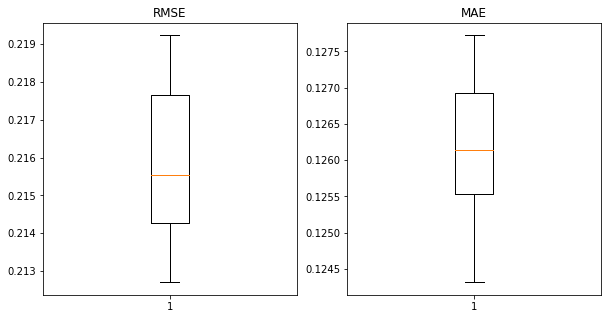

In [21]:
rmse = svd_results['test_rmse']
mae = svd_results['test_mae']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(rmse)
plt.title('RMSE')
plt.subplot(1, 2, 2)
plt.boxplot(mae)
plt.title('MAE')
plt.show()

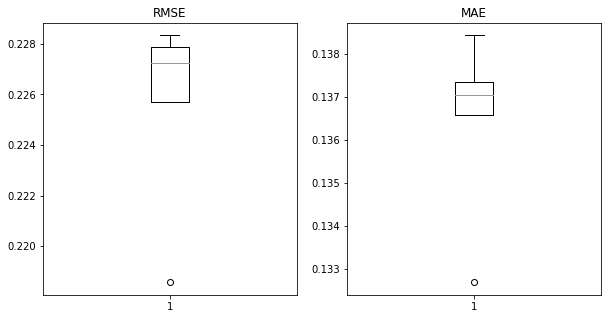

In [22]:
rmse = results_knnm['test_rmse']
mae = results_knnm['test_mae']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(rmse)
plt.title('RMSE')
plt.subplot(1, 2, 2)
plt.boxplot(mae)
plt.title('MAE')
plt.show()

In [ ]:
trainset = data.build_full_trainset()
algo_svd.fit(trainset)

In [ ]:
# Make a prediction for a specific user and item
user_id = '176449171'  # Replace with the actual user ID
game_id = 'Counter-Strike Global Offensive'  # Replace with the actual item ID
rating_prediction = algo.predict(user_id, game_id)
print(f"The estimated rating for Game {game_id} by User {user_id} is {rating_prediction.est}")

In [ ]:
from surprise import Dataset, SVD
from surprise.model_selection import GridSearchCV

param_grid = {'k': [20, 30, 40],  # Number of neighbors
              'sim_options': {'name': ['cosine', 'msd', 'pearson']}
             }

grid_search = GridSearchCV(, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=6)

grid_search.fit(data)

In [ ]:
# best RMSE score
print(grid_search.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(grid_search.best_params["rmse"])

In [17]:
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise import SVDpp

# Load your dataset
dataset = pd.read_csv('./data/filtered_steam_games.csv')

# Prepare the data for Surprise
reader = Reader(rating_scale=(dataset['Ratings'].min(), dataset['Ratings'].max()))
data = Dataset.load_from_df(dataset[['UserID', 'Game', 'Ratings']], reader)

# Define a range of hyperparameters for GridSearchCV with SVD++
param_grid = {
    'n_factors': [50, 100, 150],  # Number of factors
    'n_epochs': [20, 30],  # Number of epochs
    'lr_all': [0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.1]  # Regularization term
}

# Setup GridSearchCV with SVD++
gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fit the model
gs_svdpp.fit(data)

# Best score and parameters
best_rmse = gs_svdpp.best_score['rmse']
best_params = gs_svdpp.best_params['rmse']

print(f"Best RMSE: {best_rmse}")
print(f"Best parameters: {best_params}")


Best RMSE: 0.2087339575475221
Best parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


In [ ]:
# Need to remove outliers in the 'Hours' column for more sufficient dataset

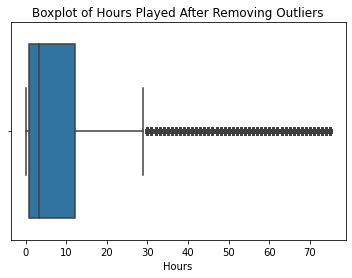

In [18]:
# Calculate IQR for 'Hours'
Q1 = dataset['Hours'].quantile(0.25)
Q3 = dataset['Hours'].quantile(0.75)
IQR = Q3 - Q1

# Define an upper bound for outliers
upper_bound = Q3 + 3 * IQR

# Removing outliers from 'Hours'
cleaned_dataset = dataset[dataset['Hours'] <= upper_bound]

# New basic statistics  after removing outliers
cleaned_numerical_stats = cleaned_dataset.describe()

# Plotting the new distribution of 'Hours'
plt.figure(figsize=(6, 4))
sns.boxplot(x=cleaned_dataset['Hours'])
plt.title('Boxplot of Hours Played After Removing Outliers')
plt.show()

In [25]:
outliers_removed = dataset.shape[0] - cleaned_dataset.shape[0]

In [26]:
outliers_removed

7024

In [24]:
# Prepare the data for Surprise
reader = Reader(rating_scale=(cleaned_dataset['Ratings'].min(), cleaned_dataset['Ratings'].max()))
data = Dataset.load_from_df(cleaned_dataset[['UserID', 'Game', 'Ratings']], reader)

# Define a range of hyperparameters
param_grid = {
    'n_factors': [50, 100, 150],  # Number of factors
    'n_epochs': [20, 30],  # Number of epochs
    'lr_all': [0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.1]  # Regularization term
}

# GridSearchCV with SVD++
gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

# Fit the model
gs_svdpp.fit(data)

# Best score and parameters
best_rmse = gs_svdpp.best_score['rmse']
best_params = gs_svdpp.best_params['rmse']

print(f"Best RMSE: {best_rmse}")
print(f"Best parameters: {best_params}")

Best RMSE: 0.18851691304301293
Best parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


In [ ]:
print(top_user_recommendations)

In [ ]:
print(sorted_predictions)

In [ ]:
# Baseline Model with filtered_data to compare with optimized SVD++

In [32]:
from surprise import Dataset, Reader, NormalPredictor
from surprise.model_selection import cross_validate

# Prepare the data for Surprise
reader_baseline = Reader(rating_scale=(filtered_data['Ratings'].min(), dataset['Ratings'].max()))
data_baseline = Dataset.load_from_df(filtered_data[['UserID', 'Game', 'Ratings']], reader)

# Define the NormalPredictor model
algo = NormalPredictor()

# Perform cross-validation and compute RMSE
results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

# Average RMSE
average_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
print(f'Average RMSE using NormalPredictor: {average_rmse}')

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2799  0.2828  0.2786  0.2789  0.2765  0.2794  0.0021  
Fit time          0.02    0.02    0.02    0.03    0.02    0.02    0.00    
Test time         0.03    0.03    0.10    0.03    0.03    0.04    0.03    
Average RMSE using NormalPredictor: 0.2793589894467298
